In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from ADE import ADE20KDataset # ADE20K數據集的模組
from torchvision import transforms
from torchvision.transforms import Resize
import torchvision.transforms.functional as F

import plotly.express as pe
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### 載入VOC2007資料集

- 資料特性解說， Object Detection僅使用到 JPEGImages 與 Annotations 
    - https://jason-chen-1992.weebly.com/home/pascal-dataset
- XML檔案處理
    - https://github.com/bnsreenu/python_for_microscopists/blob/master/285-Object%20detection%20using%20Mask%20R%20CNN%20with%20XML%20annotated%20data/285-fruits_mask_rcnn.py
- VOCDetection 參數
    - https://pytorch.org/vision/stable/generated/torchvision.datasets.VOCDetection.html


In [2]:
# 設置數據集路徑和清單
voc_root = '/git/Kaiyang/hw4data'

In [3]:
voc_train = VOCDetection(root=voc_root, year='2007', image_set='train')


In [4]:
print(voc_train[0][0]) #照片
print(voc_train[0][1]) #xml檔資訊

<PIL.Image.Image image mode=RGB size=335x500 at 0x7FDC87002320>
{'annotation': {'folder': 'VOC2007', 'filename': '000002.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '329145082'}, 'owner': {'flickrid': 'hiromori2', 'name': 'Hiroyuki Mori'}, 'size': {'width': '335', 'height': '500', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'train', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '139', 'ymin': '200', 'xmax': '207', 'ymax': '301'}}]}}


- VOCDetection
    - transform

In [5]:
compose = transforms.Compose([transforms.ToTensor(),
                                transforms.ConvertImageDtype(torch.float)])

- VOCDetection
    - target_transform

In [6]:
#VOC的12種類別
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
           'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
           'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [7]:
def voc_extract_xml(img):
    
    target_annotation = img["annotation"]
    
    #擷取的資料
    target = {"image_id":[], "boxes":[], "labels":[],'area':[]}
    
    #<filename>
    target["image_id"] = torch.Tensor([int(target_annotation['filename'][:-4])])

    #<size>
    width, height, depth = list(map(int, target_annotation['size'].values()))

    #<object>-<bndbox>
    for obj in target_annotation['object']:
        #label類別 <name>
        target["labels"].append(classes.index(obj["name"]))
        
        xmin = int(obj['bndbox']['xmin'])
        ymin = int(obj['bndbox']['ymin'])
        xmax = int(obj['bndbox']['xmax'])
        ymax = int(obj['bndbox']['ymax'])
        
        box = [xmin, ymin, xmax, ymax]
        target["boxes"].append(box)
        
        area = (ymax - ymin) * (xmax - ymax)
        target["area"].append(area)    
   
    
    # 轉換為tensor格式存入
    target["boxes"] = torch.FloatTensor(target["boxes"])
    target["labels"] = torch.LongTensor(target["labels"])
    target["area"] = torch.FloatTensor(target["area"])
    
    #mask
    target["masks"] = torch.zeros((len(target["boxes"]),width, height), dtype=torch.float32)

    return target

- 分別讀取train.txt、val.txt、test.txt

In [8]:
# VOC 2007物體檢測數據集
voc_train_dataset = VOCDetection(root=voc_root, year='2007', image_set='train', transform=compose, target_transform=voc_extract_xml)
voc_val_dataset = VOCDetection(root=voc_root, year='2007', image_set='val', transform=compose, target_transform=voc_extract_xml)
voc_test_dataset = VOCDetection(root=voc_root, year='2007', image_set='test', transform=compose, target_transform=voc_extract_xml)


In [9]:
print(f"VOC2007 train dataset : {len(voc_train_dataset)}")
print(f"VOC2007 val dataset : {len(voc_val_dataset)}")
print(f"VOC2007 test dataset : {len(voc_test_dataset)}")

VOC2007 train dataset : 6973
VOC2007 val dataset : 997
VOC2007 test dataset : 1993


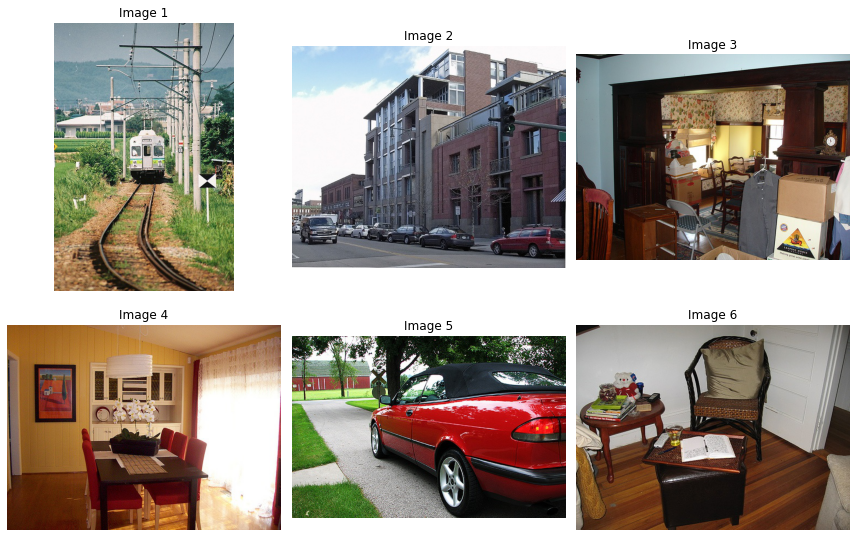

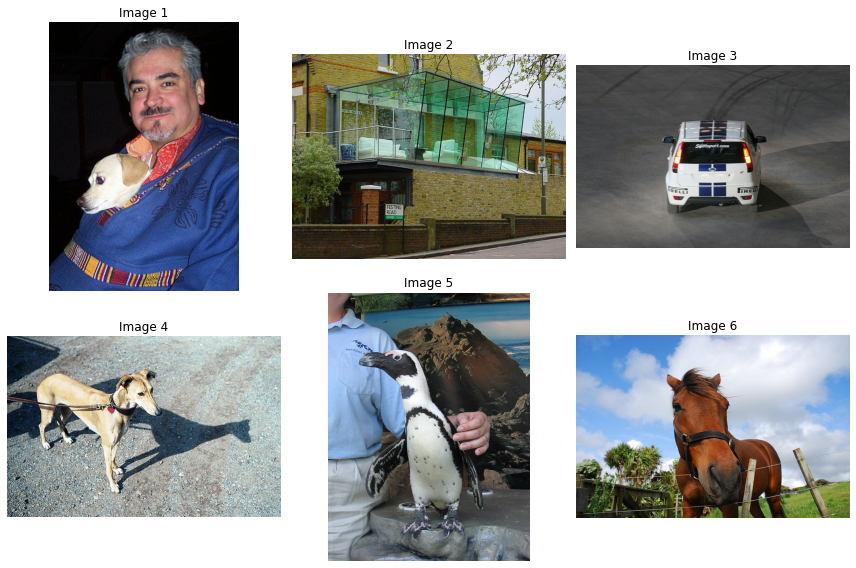

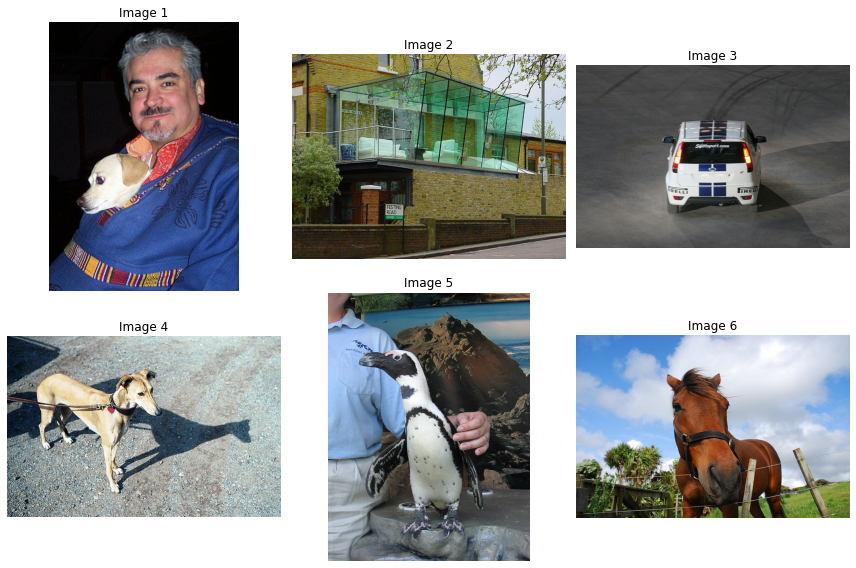

In [10]:
import matplotlib.pyplot as plt

# Define a function to visualize images
def visualize_images(dataset):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    for i, ax in enumerate(axes.flatten()):
        image, target = dataset[i]
        image = image.permute(1, 2, 0)  # Convert from tensor to numpy array
        ax.imshow(image)
        ax.set_title(f"Image {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize VOC 2007 train dataset
visualize_images(voc_train_dataset)

# Visualize VOC 2007 validation dataset
visualize_images(voc_val_dataset)

# Visualize VOC 2007 test dataset
visualize_images(voc_val_dataset)


- 顯示圖片以及box

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_image(image, boxes):
    # Create figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image)
    
    # Add bounding boxes
    for box in boxes:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
        
        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the rectangle patch to the axes
        ax.add_patch(rect)
    
    # Show the plot
    plt.show()


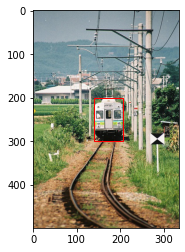

In [12]:
# Assuming you have an image tensor and the corresponding target
image = voc_train_dataset[0][0]  # Get the first image from the batch
boxes = voc_train_dataset[0][1]['boxes']  # Get the bounding boxes for the first image

# Convert the image tensor to a numpy array
image_np = image.permute(1, 2, 0).numpy()

# Visualize the image and bounding boxes
visualize_image(image_np, boxes)


### 載入ADE20K資料集
- 分別讀取train.txt、val.txt、test.txt

In [13]:
# 設置數據集路徑和清單
ade_root = '/git/Kaiyang/hw4data/ADE'

# ADE20K語義分割數據集
ade_train_dataset = ADE20KDataset(root=ade_root, split='train', transform=compose) 
ade_val_dataset = ADE20KDataset(root=ade_root, split='val', transform=compose)
ade_test_dataset = ADE20KDataset(root=ade_root, split='test', transform=compose)



In [14]:
print(f"ADE20K train dataset : {len(ade_train_dataset)}")
print(f"ADE20K val dataset : {len(ade_val_dataset)}")
print(f"ADE20K test dataset : {len(ade_test_dataset)}")

ADE20K train dataset : 1400
ADE20K val dataset : 200
ADE20K test dataset : 400


In [15]:
print(ade_test_dataset[0][1])

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3804,  ..., 0.3804, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3804,  ..., 0.3804, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.4196,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4196,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])


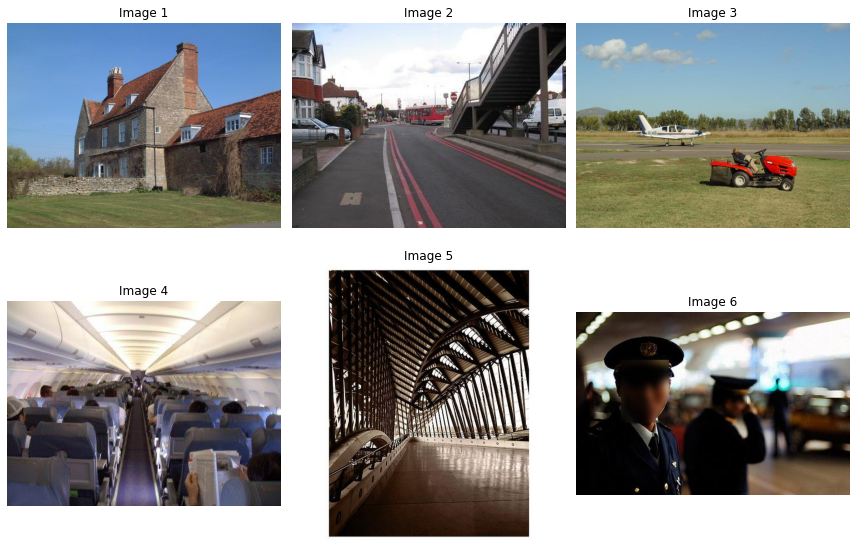

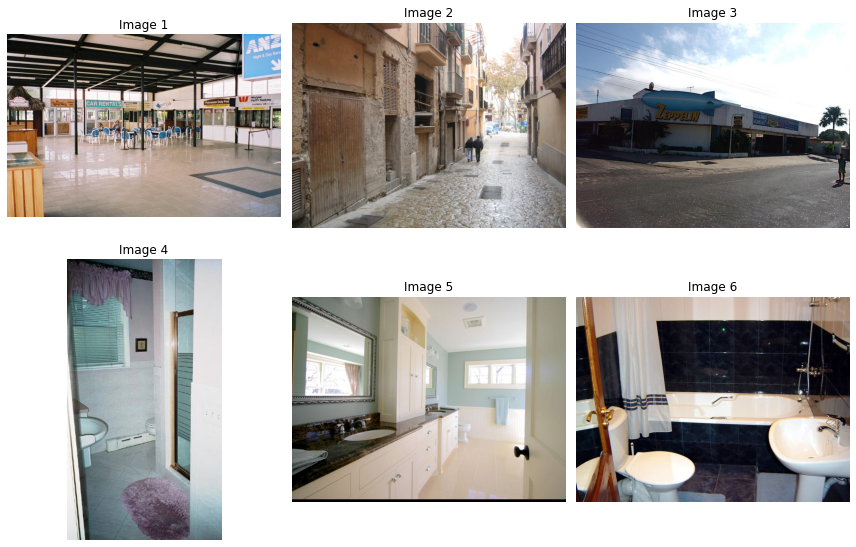

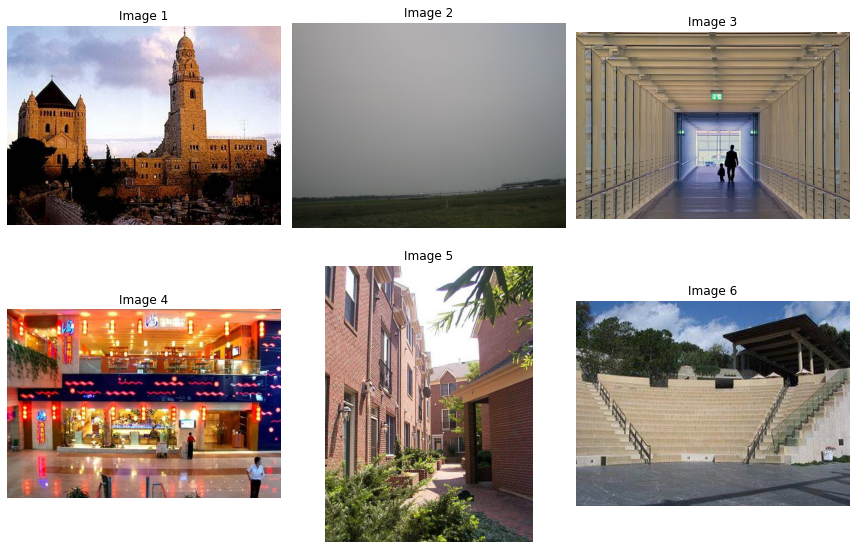

In [16]:
# Visualize ADE20K train dataset
visualize_images(ade_train_dataset)

# Visualize ADE20K validation dataset
visualize_images(ade_val_dataset)

# Visualize ADE20K validation dataset
visualize_images(ade_test_dataset)

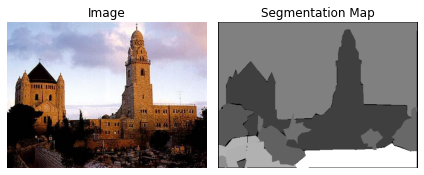

In [17]:
example_index = 0
image, mask = ade_test_dataset[example_index]


# Convert the image and mask tensors to NumPy arrays
image = image.numpy()
mask = mask.numpy()

# Visualize the image
plt.subplot(1, 2, 1)
plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')
plt.title('Image')

# Visualize the segmentation map
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Segmentation Map')

plt.tight_layout()
plt.show()


### Mask RCNN - VOC2007 + ADE20K

- model
- https://github.com/4-geeks/Mask-RCNN-pytorch/blob/master/mask_rcnn.py

In [18]:
import utils.utils
from utils.engine import train_one_epoch, evaluate
from utils.dataset import maskrcnn_Dataset, get_transform
from utils.model import get_instance_segmentation_model

In [19]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn()

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [20]:
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Pad the boxes in each target to have the same number of boxes
    max_boxes = max(len(target["boxes"]) for target in targets)
    for target in targets:
        num_boxes = len(target["boxes"])
        if num_boxes < max_boxes:
            padding = torch.zeros((max_boxes - num_boxes, 4), dtype=torch.float32)
            padded_boxes = torch.cat([torch.tensor(target["boxes"]), padding])
            target["boxes"] = padded_boxes

    return images, targets


In [21]:
#Hyperparameter
num_classes = len(classes)
num_epochs = 10
batch_size = 8

In [22]:
#voc
voc_train_dataloader = DataLoader(voc_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
voc_val_dataloader = DataLoader(voc_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
voc_test_dataloader = DataLoader(voc_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

#ade20k
ade_train_dataloader = DataLoader(ade_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
ade_val_dataloader = DataLoader(ade_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
ade_test_dataloader = DataLoader(ade_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [23]:
# MASK-RCNN MODEL

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_instance_segmentation_model(num_classes).to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=15,
                                            gamma=0.1)

In [24]:
 for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        #voc2007
        train_one_epoch(model, optimizer, voc_train_dataloader, device, epoch, print_freq=10)
        #ade20k
        train_one_epoch(model, optimizer, ade_train_dataloader, device, epoch, print_freq=10)
        
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



ValueError: All bounding boxes should have positive height and width. Found invalid box [0.0, 0.0, 0.0, 0.0] for target at index 0.